# Figure 1: Exploiting parameter correlactions 

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.optimize as optimize
import pymc3 as pm
import arviz as az
import theano.tensor as tt

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns; sns.set_theme(style='ticks', context='paper', font_scale=0.8);

%reload_ext watermark
%watermark -a "Mathieu Baltussen" -d -t -u -v -iv

Author: Mathieu Baltussen

Last updated: 2022-01-07 14:26:55

Python implementation: CPython
Python version       : 3.9.5
IPython version      : 7.28.0

matplotlib: 3.4.2
numpy     : 1.20.3
sys       : 3.9.5 | packaged by conda-forge | (default, Jun 19 2021, 00:32:32) 
[GCC 9.3.0]
scipy     : 1.6.2
pandas    : 1.2.4
pymc3     : 3.11.4
arviz     : 0.11.4
seaborn   : 0.11.1
theano    : 1.1.2



## Helper functions for plotting

In [3]:
XSIZE = 7 #inch
YSIZE = XSIZE/np.sqrt(2) #inch

def savefig(name):
    """Helper function to save figures in desired formats"""
    plt.savefig(f"../figures/{name}.svg")
    plt.savefig(f"../figures/{name}.png", dpi=300)

def generate_figure(n_col, n_row):
    """ Helper function to generate gridspec figures"""
    DX = XSIZE/n_col
    DY = YSIZE/n_col
    YLENGTH = n_row*DY

    fig = plt.figure(figsize=(XSIZE, YLENGTH), constrained_layout=True)
    gs = fig.add_gridspec(n_row, n_col)
    return fig, gs

## Model creation

Partitioning of full dataset by separate experimental conditions, 
and creation of stead-state models for every dataset partition, 
as well as the full dataset.

### Bayesian inference of a Michaelis-Menten system from steady-state data and an analytical equation

$$\frac{dS}{dt} = \frac{-V_{max}S}{K_M + S} + k_f\cdot (S_{in} - S) $$
$$\frac{dP}{dt} = \frac{V_{max}S}{K_M + S} - k_f\cdot P $$

In steady-state ($dP/dt = dS/dt = 0$), this can be implicitly written as:

$$P_{ss} =  \frac{V_{max}S}{k_f*(K_M + S)}$$

or rewritten using $S = S_{in} - P_{ss}$:

$$P_{ss} = 0.5(V_{max}/k_f + K_M + S_{in}) - 0.5\sqrt{(V_{max}/k_f + K_M + S_{in})^2-4S_{in}V_{max}/k_f} $$



We know $S_{in}$ and observe corresponding $P_{ss}$ (including noise), so we can infere the parameters $V_{max}$ and $K_M$ from this data. *A priori* we only know that both parameters should be positive-definite.

In [5]:
data = pd.read_csv("../data/CEKS33.csv")
kf = 0.125  # minute^-1
E = 0.012
data = data.assign(kf=kf, Tr=E)
data_1 = data[data.AAA == 0]
data_2 = data[data.AAA != 0]

with pm.Model() as model_1:
    k_cat = pm.Uniform("k_cat", 0, 500)
    K_M = pm.Uniform("K_M", 0, 500)
    K_I = pm.Uniform("K_I", 1000, 10000)
    sigma = pm.Exponential("sigma", 10)

    S_in = data_1["R"].values
    I_in = data_1["AAA"].values
    P_obs = data_1["AMC"].values
    S_obs = S_in - P_obs # Substrate concentration inside reactor determined via stoichiometric conservation at steady-state
    E = data_1["Tr"].values
    kf = data_1["kf"].values
    
    # Inference of probabilistic model at steady-state conditions
    P = pm.Normal(
        "obs", mu=k_cat * E * S_obs / (kf * (K_M + S_obs*(1+I_in/K_I))), sigma=sigma, observed=P_obs
    )
    idata_1 = pm.sample(
        1000,
        tune=1000,
        cores=4,
        step=pm.NUTS(target_accept=0.95),
        return_inferencedata=True,
    )

with pm.Model() as model_2:
    k_cat = pm.Uniform("k_cat", 0, 500)
    K_M = pm.Uniform("K_M", 0, 500)
    K_I = pm.Uniform("K_I", 1000, 10000)
    sigma = pm.Exponential("sigma", 10)

    S_in = data_2["R"].values
    I_in = data_2["AAA"].values
    P_obs = data_2["AMC"].values
    S_obs = S_in - P_obs # Substrate concentration inside reactor determined via stoichiometric conservation at steady-state
    E = data_2["Tr"].values
    kf = data_2["kf"].values

    # Inference of probabilistic model at steady-state conditions
    P = pm.Normal(
        "obs", mu=k_cat * E * S_obs / (kf * (K_M + S_obs*(1+I_in/K_I))), sigma=sigma, observed=P_obs
    )
    idata_2 = pm.sample(
        1000,
        tune=1000,
        cores=4,
        step=pm.NUTS(target_accept=0.95),
        return_inferencedata=True,
    )

with pm.Model() as model:
    k_cat = pm.Uniform("k_cat", 0, 500)
    K_M = pm.Uniform("K_M", 0, 500)
    K_I = pm.Uniform("K_I", 1000, 10000)
    sigma = pm.Exponential("sigma", 10)

    S_in = data["R"].values
    I_in = data["AAA"].values
    P_obs = data["AMC"].values
    S_obs = S_in - P_obs # Substrate concentration inside reactor determined via stoichiometric conservation at steady-state
    E = data["Tr"].values
    kf = data["kf"].values

    # Inference of probabilistic model at steady-state conditions
    P = pm.Normal(
        "obs", mu=k_cat * E * S_obs / (kf * (K_M + S_obs*(1+I_in/K_I))), sigma=sigma, observed=P_obs
    )
    idata = pm.sample(
        1000,
        tune=1000,
        cores=4,
        step=pm.NUTS(target_accept=0.95),
        return_inferencedata=True,
    )

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, K_I, K_M, k_cat]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, K_I, K_M, k_cat]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, K_I, K_M, k_cat]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


## Posterior and Posterior Predictive distributions


In [6]:
posterior_df_1 = idata_1.to_dataframe(['posterior'])
posterior_df_2 = idata_2.to_dataframe(['posterior'])
posterior_df = idata.to_dataframe(['posterior'])

with model_1:
    post_pred_1 = pm.sample_posterior_predictive(idata_1, var_names=['obs', 'k_cat', 'K_M', 'K_I', 'sigma'])
posterior_df_1 = pd.DataFrame({'k_cat': post_pred_1['k_cat'], 'K_M': post_pred_1['K_M'], 'K_I': post_pred_1['K_I'],'sigma': post_pred_1['sigma']})
with model_2:
    post_pred_2 = pm.sample_posterior_predictive(idata_2, var_names=['obs', 'k_cat', 'K_M', 'K_I', 'sigma'])
posterior_df_2 = pd.DataFrame({'k_cat': post_pred_2['k_cat'], 'K_M': post_pred_2['K_M'], 'K_I': post_pred_2['K_I'],'sigma': post_pred_2['sigma']})
with model:
    post_pred = pm.sample_posterior_predictive(idata, var_names=['obs', 'k_cat', 'K_M', 'K_I', 'sigma'])
posterior_df = pd.DataFrame({'k_cat': post_pred['k_cat'], 'K_M': post_pred['K_M'], 'K_I': post_pred['K_I'],'sigma': post_pred['sigma']})

## Creation of the figure

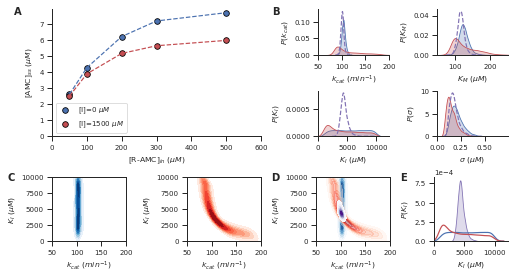

In [7]:
fig, gs = generate_figure(4,3)

ax_1 = fig.add_subplot(gs[0:2,:2])
ax_1.scatter(data_1.R, data_1.AMC, ec='black', fc='C0', label=r"[I]=0 $\mu M$", s=32)
ax_1.scatter(data_2.R, data_2.AMC, ec='black', fc='C3', label=r"[I]=1500 $\mu M$", s=32)
ax_1.plot(data_1.R, data_1.AMC, '--', c='C0')
ax_1.plot(data_2.R, data_2.AMC, '--', c='C3')
ax_1.legend()
ax_1.set_xlim(0, 600)
ax_1.set_ylim(0)
ax_1.text(-0.18, 0.95, 'A', transform=ax_1.transAxes, weight="bold", size=10)
ax_1.set_xlabel(r"$[$R-AMC$]_{in}~(\mu M)$")
ax_1.set_ylabel(r"$[$AMC$]_{ss}~(\mu M)$")
sns.despine(ax=ax_1)

ax_2 = gs[0:2,2:].subgridspec(2,2)
ax_3 = fig.add_subplot(gs[2,0])
ax_4 = fig.add_subplot(gs[2,1])
ax_5 = fig.add_subplot(gs[2,2])
ax_6 = fig.add_subplot(gs[2,3])

ax_2_axes = ax_2.subplots()

ax = ax_2_axes[0][0]
sns.kdeplot(posterior_df_1["k_cat"], ax=ax, fill=True, color='C0')
sns.kdeplot(posterior_df_2["k_cat"], ax=ax, fill=True, color='C3')
sns.kdeplot(posterior_df["k_cat"], ax=ax, fill=False, color='C4', linestyle="--", alpha=0.8)
sns.despine(ax=ax)
ax.set_xlim(50, 200)
ax.set_ylabel(r"$P(k_{cat})$")
ax.set_xlabel(r"$k_{cat}~(min^{-1})$")
ax.text(-0.65, 0.88, 'B', transform=ax.transAxes, weight="bold", size=10)

ax = ax_2_axes[0][1]
sns.kdeplot(posterior_df_1["K_M"], ax=ax, fill=True, color='C0')
sns.kdeplot(posterior_df_2["K_M"], ax=ax, fill=True, color='C3')
sns.kdeplot(posterior_df["K_M"], ax=ax, fill=False, color='C4', linestyle="--", alpha=0.8)
sns.despine(ax=ax)
ax.set_xlim(50, 250)
ax.set_ylabel(r"$P(K_{M})$")
ax.set_xlabel(r"$K_{M}~(\mu M)$")

ax = ax_2_axes[1][0]
sns.kdeplot(posterior_df_1["K_I"], ax=ax, fill=True, color='C0')
sns.kdeplot(posterior_df_2["K_I"], ax=ax, fill=True, color='C3')
sns.kdeplot(posterior_df["K_I"], ax=ax, fill=False, color='C4', linestyle="--", alpha=0.8)
sns.despine(ax=ax)
ax.set_xlim(0)
ax.set_ylabel(r"$P(K_{I})$")
ax.set_xlabel(r"$K_{I}~(\mu M)$")

ax = ax_2_axes[1][1]
sns.kdeplot(posterior_df_1["sigma"], ax=ax, fill=True, color='C0')
sns.kdeplot(posterior_df_2["sigma"], ax=ax, fill=True, color='C3')
sns.kdeplot(posterior_df["sigma"], ax=ax, fill=False, color='C4', linestyle="--", alpha=0.8)
sns.despine(ax=ax)
ax.set_xlim(0)
ax.set_ylabel(r"$P(\sigma)$")
ax.set_xlabel(r"$\sigma~(\mu M)$")

sns.kdeplot(data=posterior_df_1, ax=ax_3,
            x='k_cat', y='K_I', fill=True, cmap="Blues"
                )
ax_3.set_ylim(0, 10000)
ax_3.set_xlim(50, 200)
ax_3.set_ylabel(r"$K_{I}~(\mu M)$")
ax_3.set_xlabel(r"$k_{cat}~(min^{-1})$")
ax_3.text(-0.6, 0.95, 'C', transform=ax_3.transAxes, weight="bold", size=10)

sns.kdeplot(data=posterior_df_2, ax=ax_4,
            x='k_cat', y='K_I', fill=True, cmap="Reds"
                )
ax_4.set_ylim(0, 10000)
ax_4.set_xlim(50, 200)
ax_4.set_ylabel(r"$K_{I}~(\mu M)$")
ax_4.set_xlabel(r"$k_{cat}~(min^{-1})$")

sns.kdeplot(data=posterior_df_1, ax=ax_5,
            x='k_cat', y='K_I', fill=True, cmap="Blues", alpha=0.4,
                )
sns.kdeplot(data=posterior_df_2, ax=ax_5,
            x='k_cat', y='K_I', fill=True, cmap="Reds", alpha=0.4,
                )
sns.kdeplot(data=posterior_df, ax=ax_5,
            x='k_cat', y='K_I', fill=True, cmap="Purples"
                )
ax_5.set_ylim(0, 10000)
ax_5.set_xlim(50, 200)
ax_5.set_ylabel(r"$K_{I}~(\mu M)$")
ax_5.set_xlabel(r"$k_{cat}~(min^{-1})$")
ax_5.text(-0.6, 0.95, 'D', transform=ax_5.transAxes, weight="bold", size=10)

ax = ax_6
sns.kdeplot(posterior_df_1["K_I"], ax=ax, fill=False, color='C0')
sns.kdeplot(posterior_df_2["K_I"], ax=ax, fill=False, color='C3')
sns.kdeplot(posterior_df["K_I"], ax=ax, fill=True, color='C4')
sns.despine(ax=ax)
ax.set_xlim(0)
ax.set_ylabel(r"$P(K_{I})$")
ax.set_xlabel(r"$K_{I}~(\mu M)$")
ax.ticklabel_format(style='sci', scilimits=(-1,1), axis='y')
ax.text(-0.45, 0.95, 'E', transform=ax.transAxes, weight="bold", size=10)

savefig("fig_correlations")

plt.show()